# Project 3: Web APIs & NLP -03

# Preprocessing & Modeling

## Libraries

In [69]:
#working in the dataframes 
import pandas as pd
import numpy as np
from collections import Counter

#graphing 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#using nlp 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
nltk.download('words')

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

#interpretation on the models 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from IPython.display import Image
from wordcloud import WordCloud
from itertools import cycle
from scipy import interp
import scoring as sc
from tqdm import tqdm
import string
import re
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\clair\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Load in Datasets

### Summary statistics
Summary statistics refer to numerical measures that provide a concise overview of a dataset

In [2]:
#Read in the data
df_flights = pd.read_csv('../data/flights_cleaned.csv')
#Check to see if it worked
df_flights.head()

,subreddit,text
0,Flights,"$9AUD Flight To date, I just purchased my chea..."
1,Flights,I'm an engineer with a design to reverse engin...
2,Flights,TAP AIR FLIGHT SONG
3,Flights,what would you do? awful rule regarding Porter...
4,Flights,EVA Air CC Verification


In [3]:
df_hotels = pd.read_csv('../data/hotels_cleaned.csv')
#Check to see if it worked
df_hotels.head()

,subreddit,text
0,hotels,Double booking + egregious hotel cancellation ...
1,hotels,Hotel Managment Hello All! \nI am currently ap...
2,hotels,Parking pass
3,hotels,A Journey Through The Oceana Hotel Culinary Wo...
4,hotels,Chime Card at Las Vegas Hotels


In [4]:
df_flights.describe().T

,count,unique,top,freq
subreddit,4933,1,Flights,4933
text,4933,4933,"$9AUD Flight To date, I just purchased my chea...",1


In [5]:
df_hotels.describe().T

,count,unique,top,freq
subreddit,4767,1,hotels,4767
text,4767,4767,Double booking + egregious hotel cancellation ...,1


In [6]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4933 non-null   object
 1   text       4933 non-null   object
dtypes: object(2)
memory usage: 77.2+ KB


In [7]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4767 entries, 0 to 4766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4767 non-null   object
 1   text       4767 non-null   object
dtypes: object(2)
memory usage: 74.6+ KB


In [8]:
#  exploring patterns in the text to assess how best to cleanse the data
pat_list = [r'\d', '-', '\+', ':', '!', '\?', '\.', '\\n'] # list of special characters/punctuation to search for in data

def punc_search(df, col, pat):
    """
    function that counts the number of narratives
    that contain a pre-defined list of special
    characters and punctuation
    """
    for p in pat:
        v = df[col].str.contains(p).sum() # total n_rows that contain the pattern
        print(f'{p} special character is present in {v} entries')



In [9]:
punc_search(df_flights, 'text', pat_list)

\d special character is present in 2397 entries
- special character is present in 2380 entries
\+ special character is present in 143 entries
: special character is present in 813 entries
! special character is present in 825 entries
\? special character is present in 3214 entries
\. special character is present in 3027 entries
\n special character is present in 1855 entries


In [10]:
punc_search(df_hotels, 'text', pat_list)

\d special character is present in 849 entries
- special character is present in 2793 entries
\+ special character is present in 33 entries
: special character is present in 325 entries
! special character is present in 183 entries
\? special character is present in 434 entries
\. special character is present in 687 entries
\n special character is present in 194 entries


In [11]:
# define the regular expression pattern
pattern = '[' + string.punctuation + ']'

# remove all punctuation from the 'text' column
df_flights['text'] = df_flights['text'].str.replace(pattern, '')


C:\Users\clair\AppData\Local\Temp\ipykernel_9992\4029845065.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_flights['text'] = df_flights['text'].str.replace(pattern, '')
C:\Users\clair\AppData\Local\Temp\ipykernel_9992\4029845065.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_hotels['text'] = df_hotels['text'].str.replace(pattern, '')


In [22]:
df_hotels['text'] = df_hotels['text'].str.replace(pattern, '')

C:\Users\clair\AppData\Local\Temp\ipykernel_9992\3433755135.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_hotels['text'] = df_hotels['text'].str.replace(pattern, '')


### remove non-english words

In [12]:
def removeNonEnglishWordsFunct(x):
    words = set(nltk.corpus.words.words())
    filteredSentence = " ".join(w for w in nltk.wordpunct_tokenize(x) \
                                if w.lower() in words or not w.isalpha())
    return filteredSentence

In [13]:
df_flights["text"] = df_flights["text"].apply(removeNonEnglishWordsFunct)
df_flights = df_flights[df_flights["text"] != ""]

In [14]:
df_hotels["text"] = df_hotels["text"].apply(removeNonEnglishWordsFunct)
df_hotels = df_hotels[df_hotels["text"] != ""]

### Visualization

In [15]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

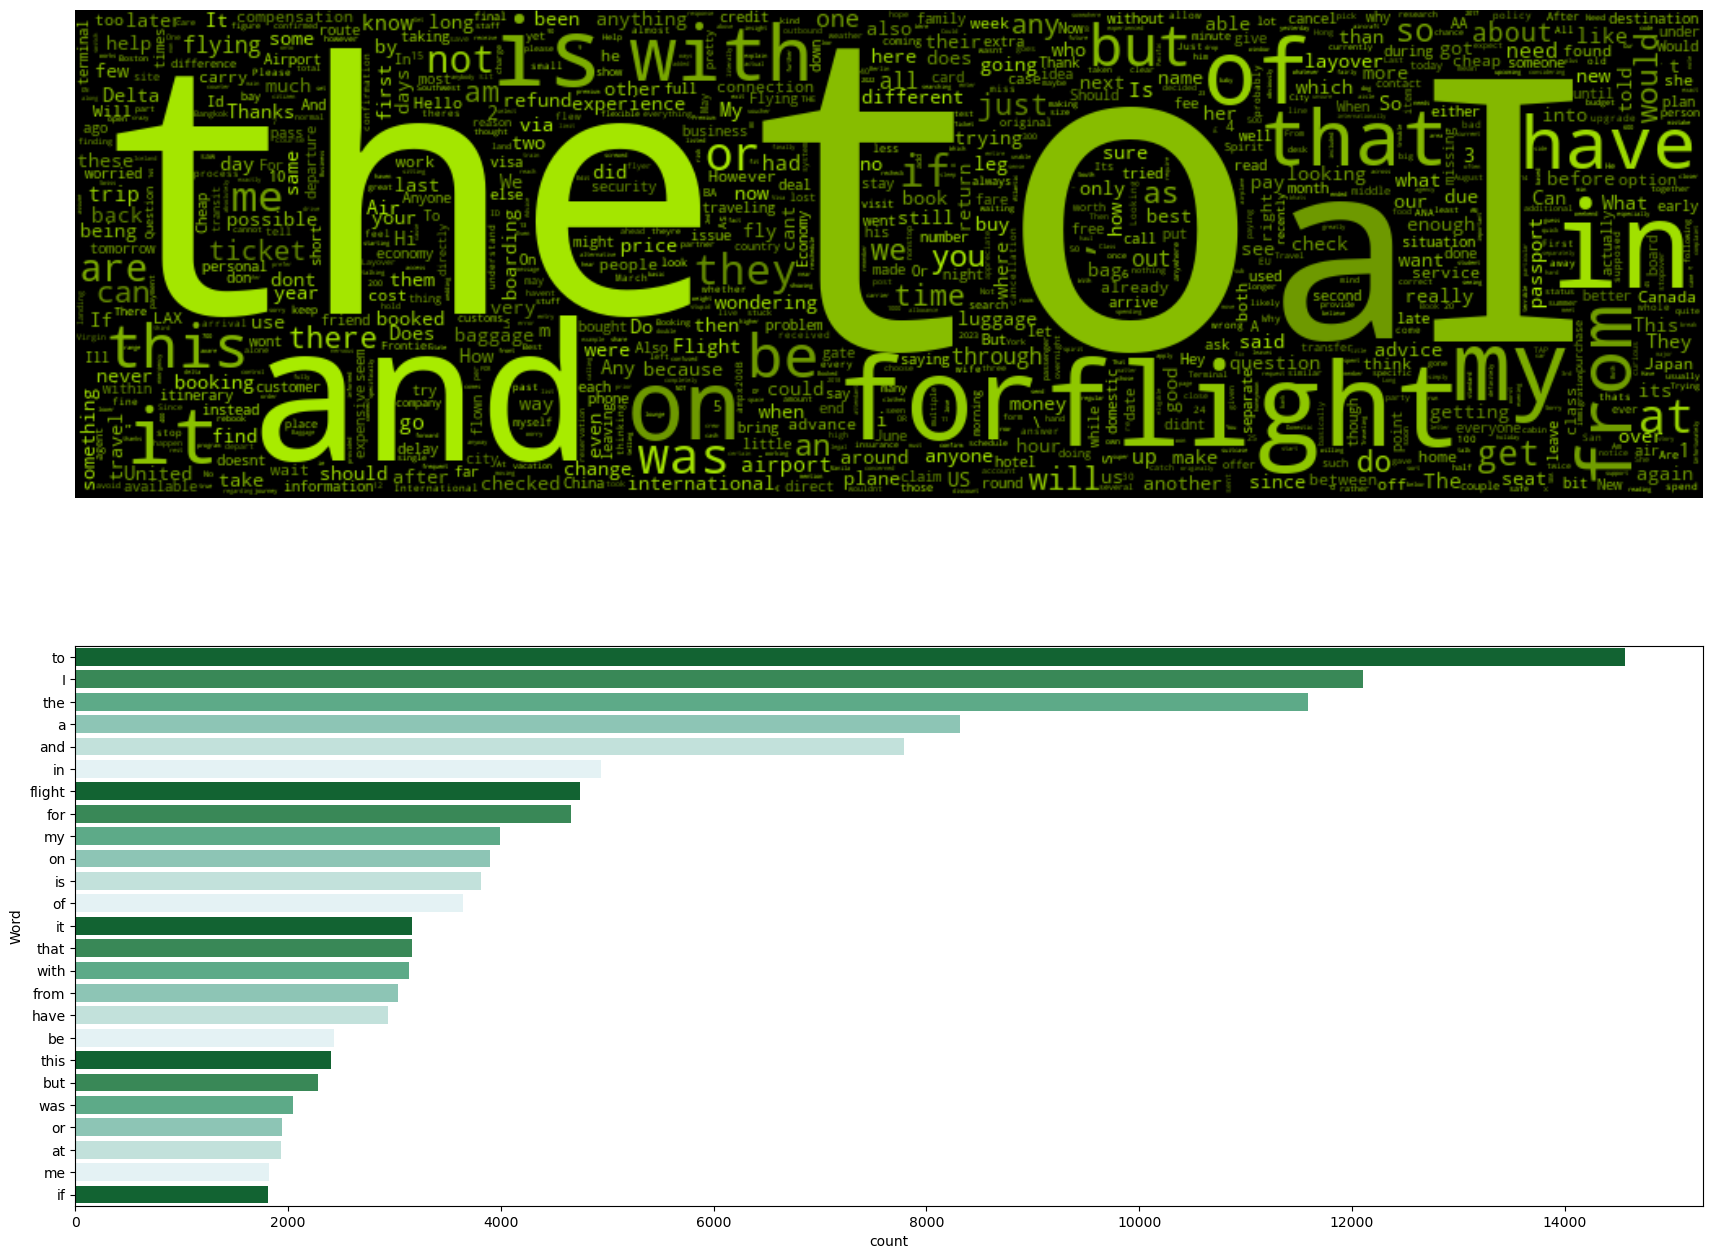

In [16]:
# plot 25 most frequent words 
freq_words(df_flights['text'], 25)

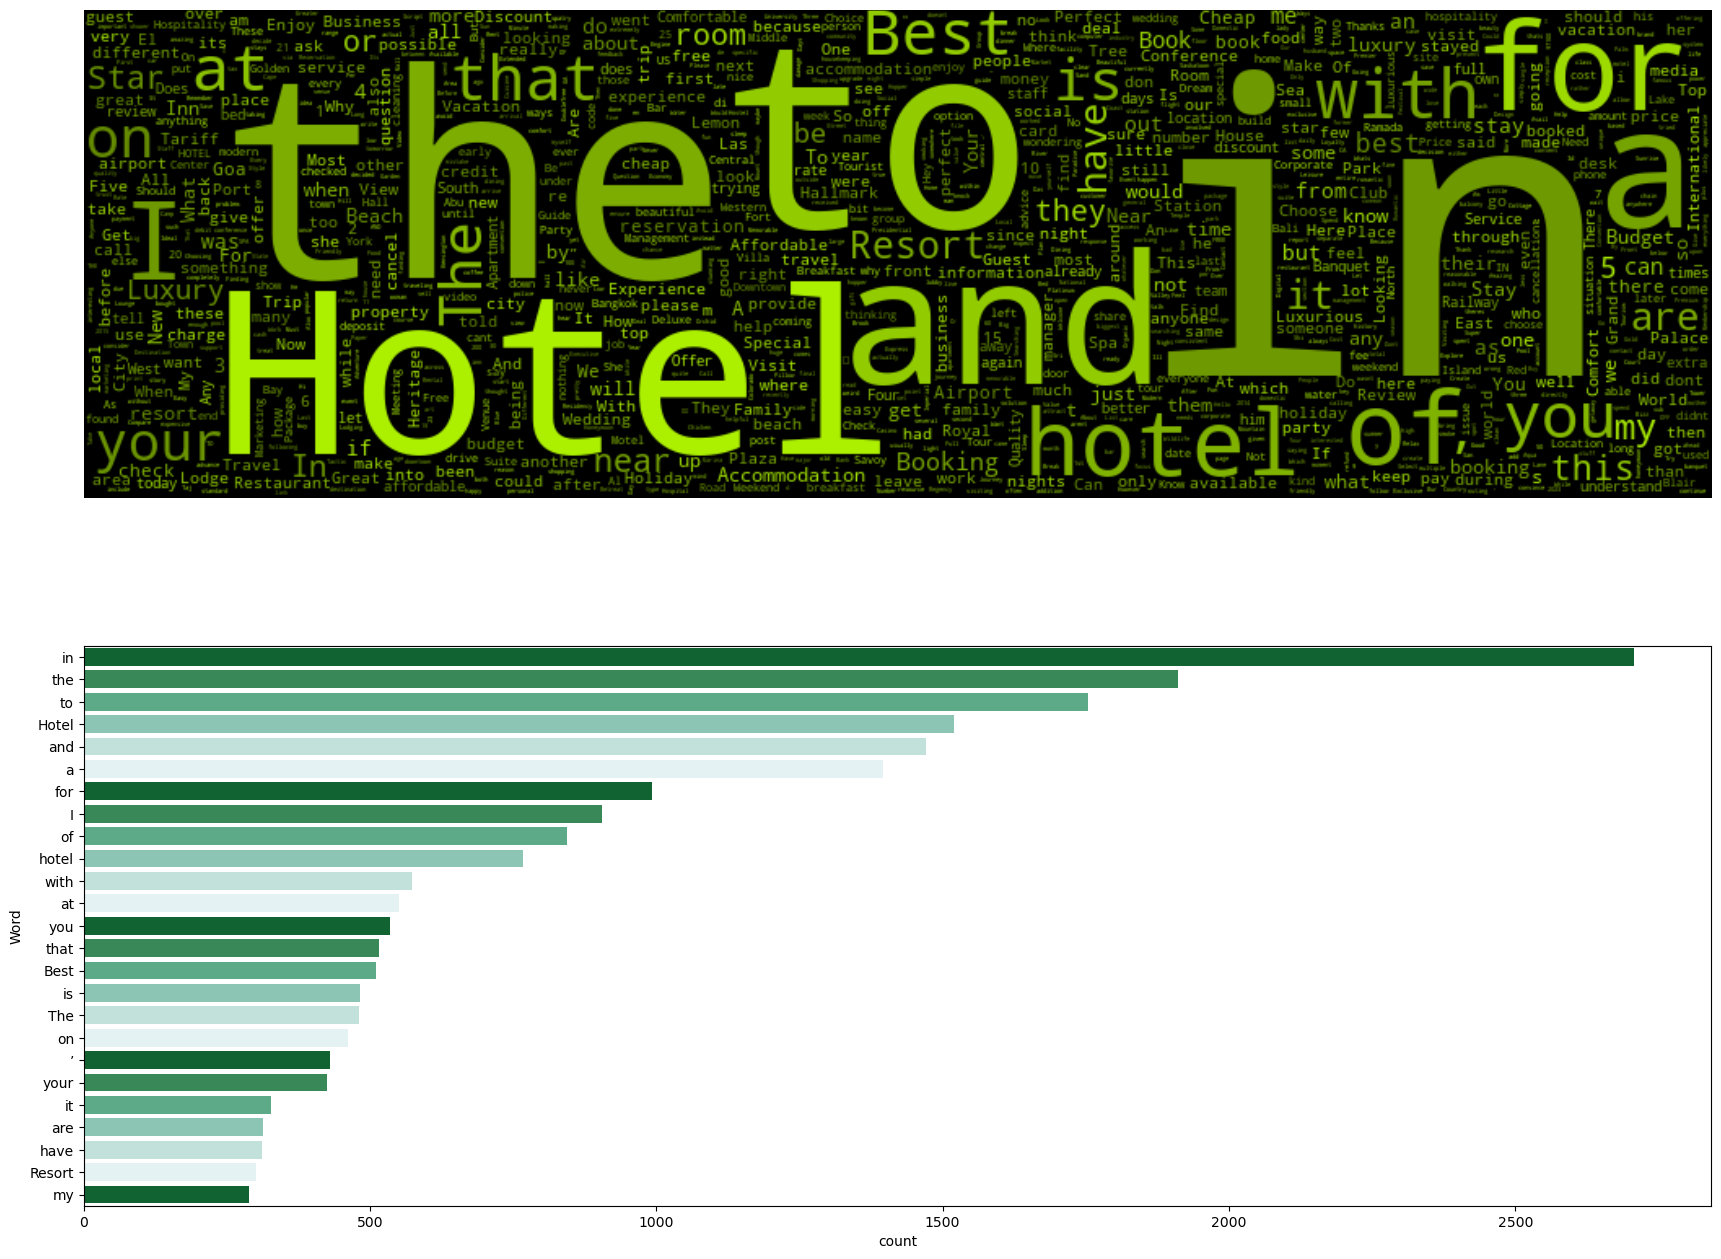

In [17]:
# plot 25 most frequent words 
freq_words(df_hotels['text'], 25)

## Stopwords

Stopwords are often removed from text data before processing it for natural language processing (NLP) tasks such as text classification, sentiment analysis, and topic modeling. This is because they can interfere with the accuracy and efficiency of these tasks by increasing the noise-to-signal ratio in the text data.

In [18]:
# stopwords-to compare text data with and without stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
additional_stopwords = ["book", "flight", "hotel", "Hotel",
                     "just", "time", "like",
                     "resort","airline","fly"]
stop_words.update(additional_stopwords)
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [19]:
df_flights['text'] = df_flights['text'].apply(lambda x: remove_stopwords(x))

In [23]:
df_hotels['text'] = df_hotels['text'].apply(lambda x: remove_stopwords(x))

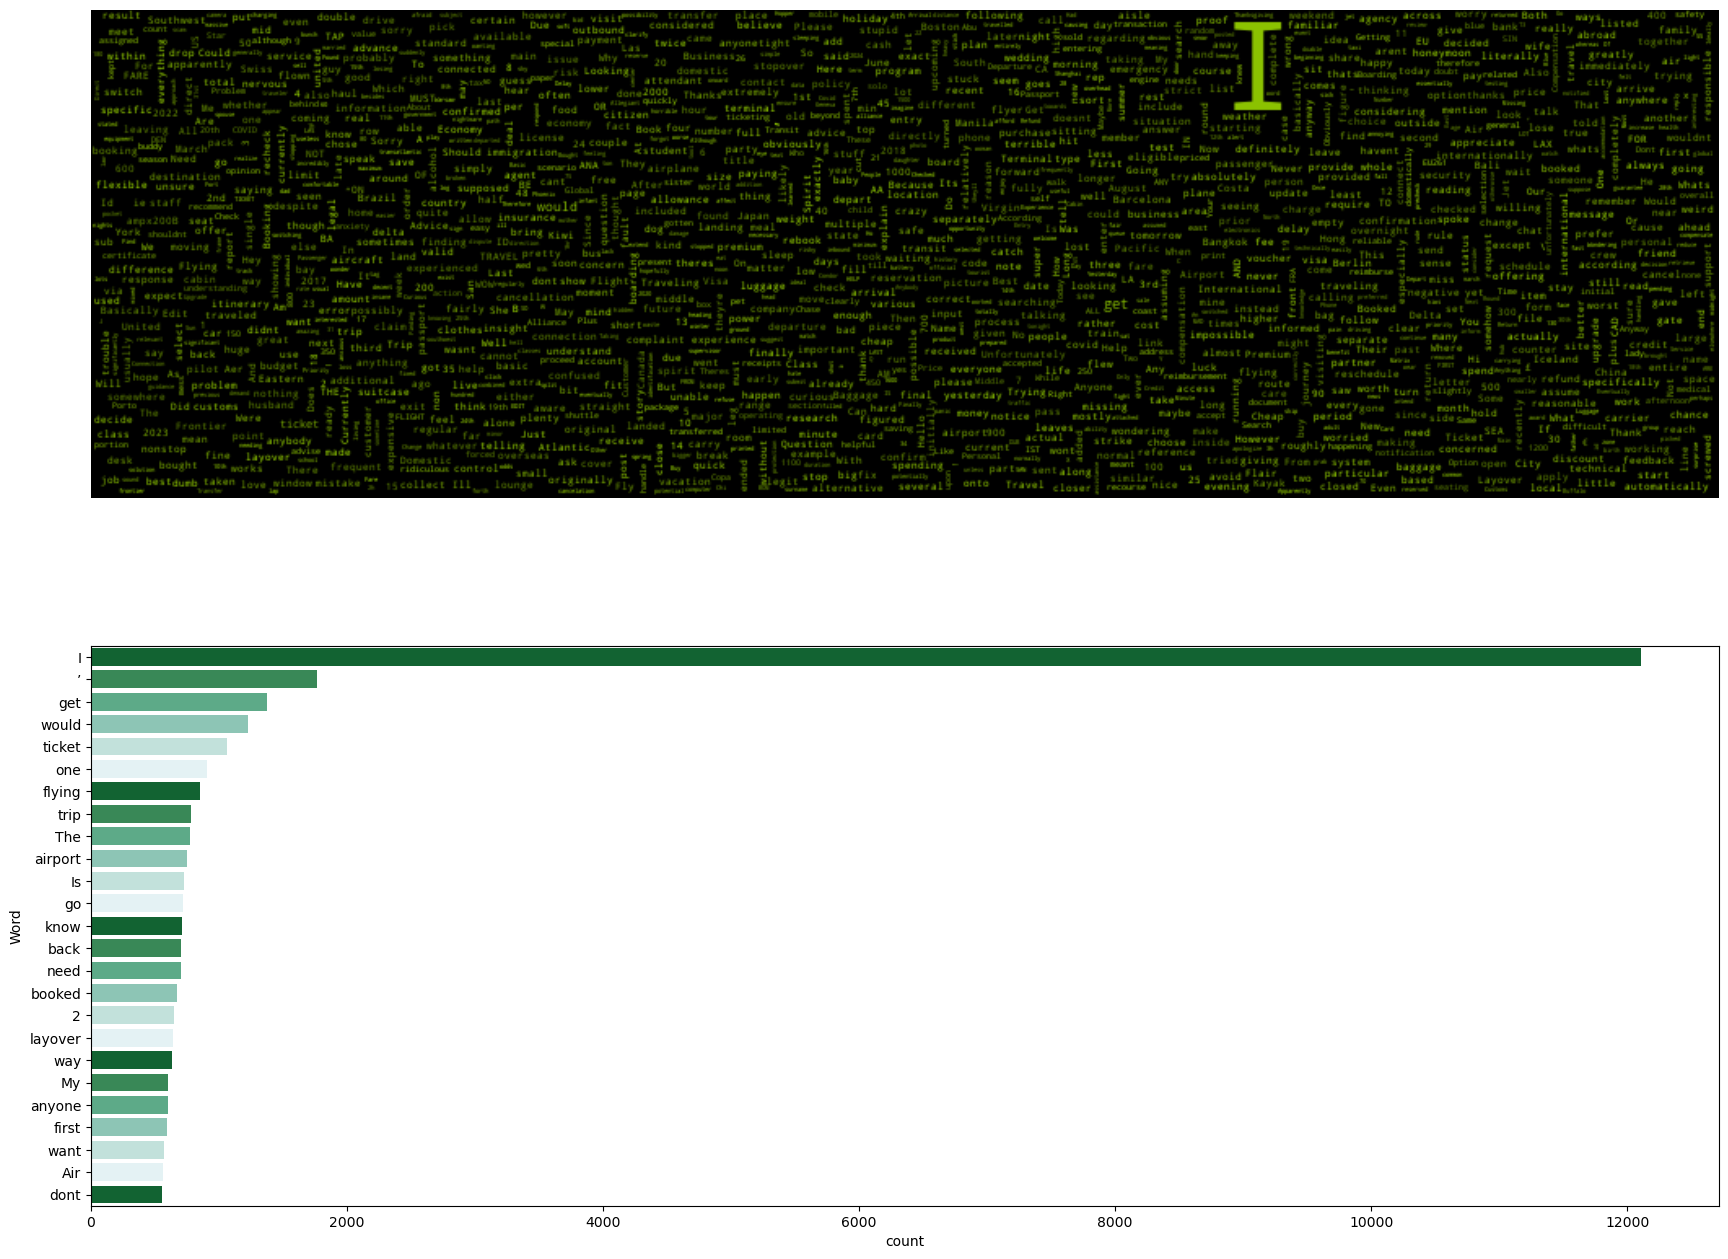

In [25]:
# plot 25 most frequent words without stopwords
freq_words(df_flights['text'], 25)

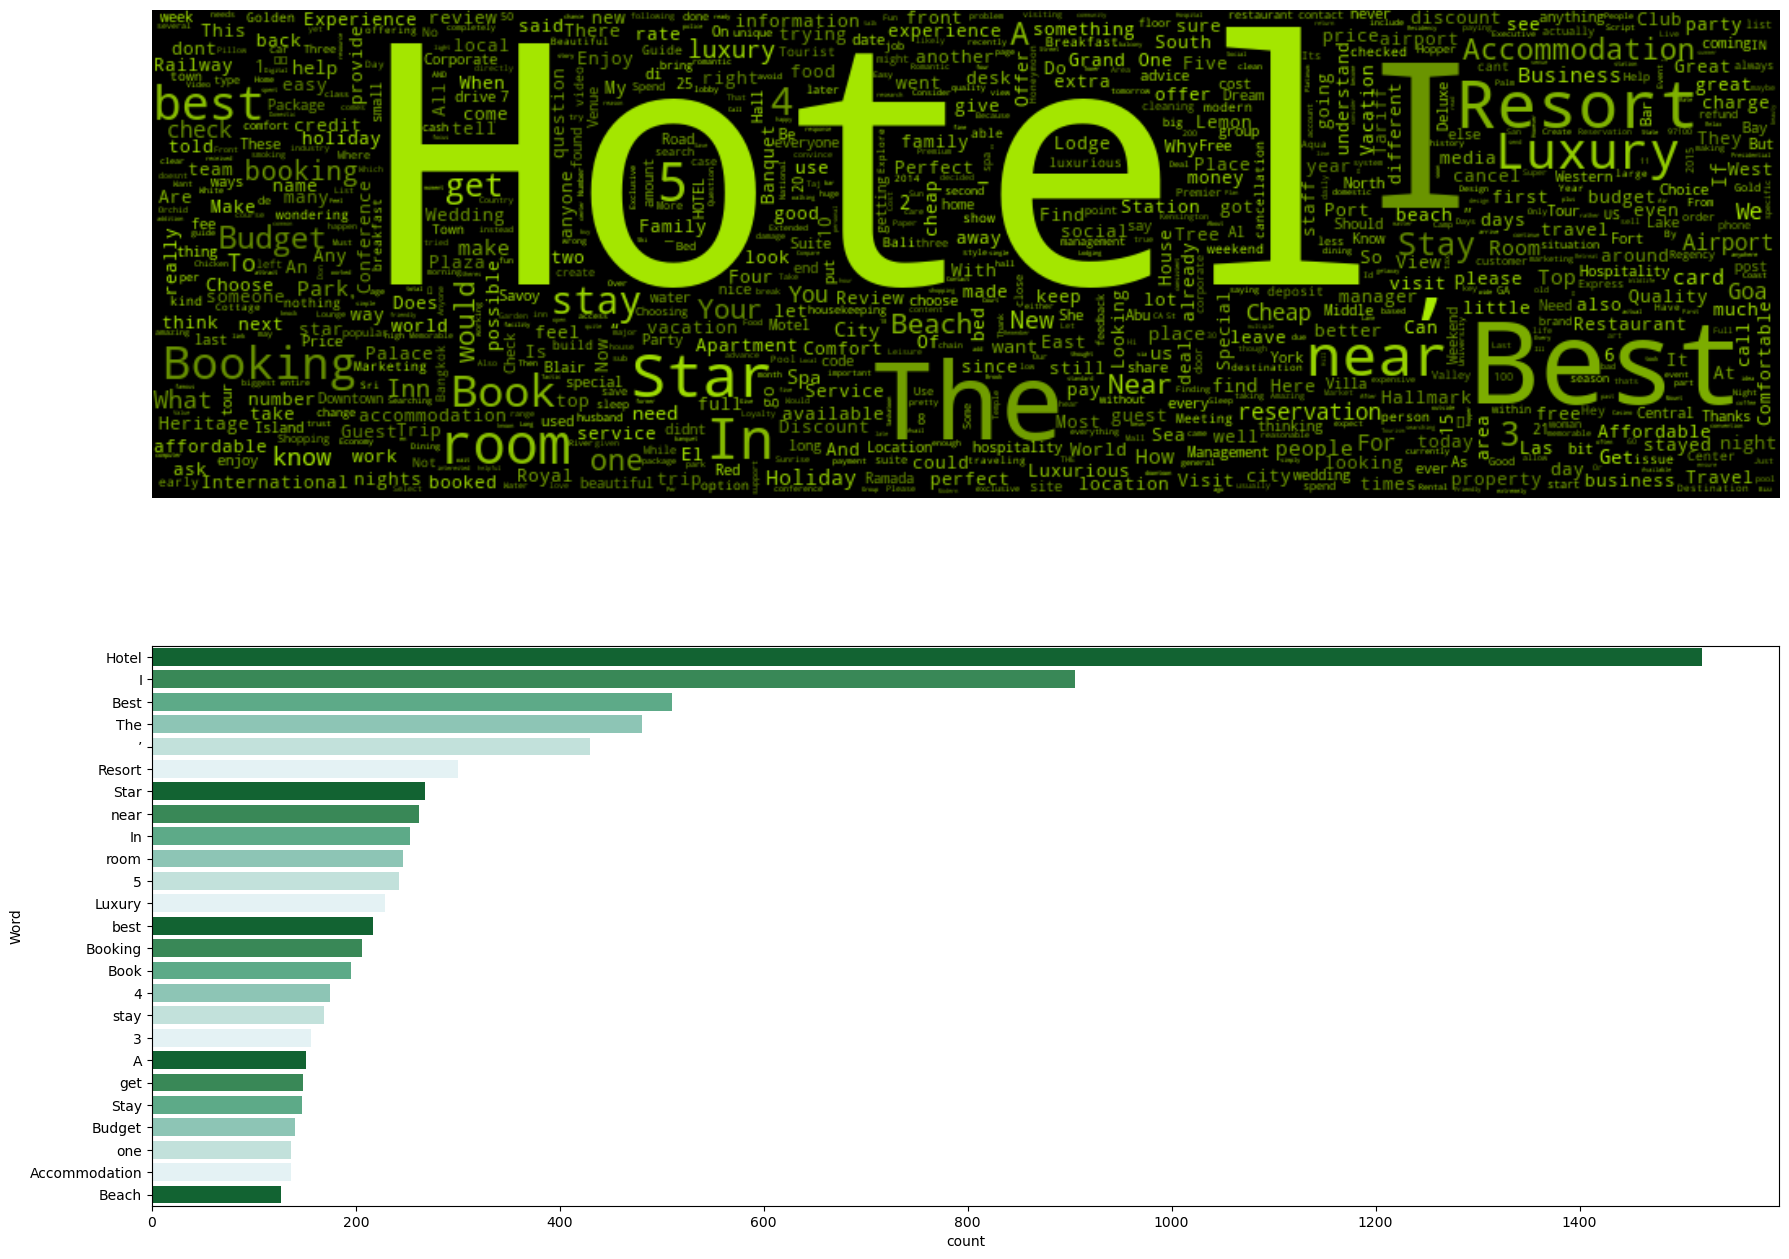

In [24]:
# plot 25 most frequent words without stopwords
freq_words(df_hotels['text'], 25)

<Figure size 1600x1600 with 0 Axes>

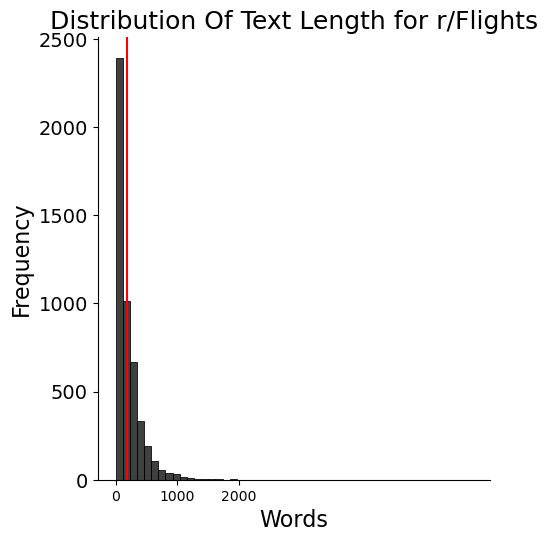

In [26]:
# Generating a list of text lengths for flights

lengths = [len(text) for text in df_flights["text"]]

# Plotting the text lengths

plt.figure(figsize = (16,16), facecolor = "white")
sns.displot(lengths, kde = False, bins = 50, color = "black")
plt.axvline(np.mean(lengths), color = "red")
plt.title("Distribution Of Text Length for r/Flights", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,2550,1000),size =10)
plt.yticks(size = 14);

# The red line marks the mean length

<Figure size 800x800 with 0 Axes>

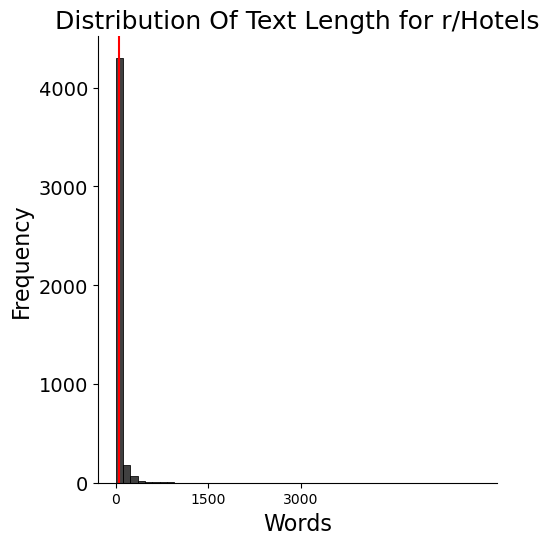

In [27]:
# Generating a list of text lengths for hotels

lengths = [len(text) for text in df_hotels["text"]]

# Plotting the text lengths

plt.figure(figsize = (8,8), facecolor = "white")
sns.displot(lengths, kde = False, bins = 50, color = "black")
plt.axvline(np.mean(lengths), color = "red")
plt.title("Distribution Of Text Length for r/Hotels", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,3550,1500),size =10)
plt.yticks(size = 14);

# The red line marks the mean length

In [28]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4610 entries, 0 to 4766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4610 non-null   object
 1   text       4610 non-null   object
dtypes: object(2)
memory usage: 108.0+ KB


In [29]:
def plot_most_frequent_words(dataframes, titles):
    
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common 20 Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size=25)

## Count vectorizer

CountVectorizer is a feature extraction technique used in Natural Language Processing (NLP) to convert a collection of text documents to a matrix of token counts. It is a common technique used for text classification, sentiment analysis, and topic modeling.

In CountVectorizer, each document is represented as a vector of token counts, where each token represents a word in the document vocabulary. The number of times a token appears in a document is counted and stored in the corresponding element of the vector. For example, consider the following two documents:

CountVectorizer also includes several optional parameters, such as n-gram range, minimum document frequency, and maximum document frequency, which can be used to customize the vectorization process and improve the accuracy of the machine learning model.

In [30]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words

cvec_flights     = CountVectorizer(stop_words = "english")
cvec_hotels = CountVectorizer(stop_words = "english")

# Subsetting the dataframe

flights     = df_flights[df_flights["subreddit"]  == 'Flights']
hotels = df_hotels[df_hotels["subreddit"] == 'hotels']

# Fit-transforming the vectorizer

vec_flights     = cvec_flights.fit_transform(flights["text"])
vec_hotels = cvec_hotels.fit_transform(hotels["text"])

C:\Users\clair\miniconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\clair\miniconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


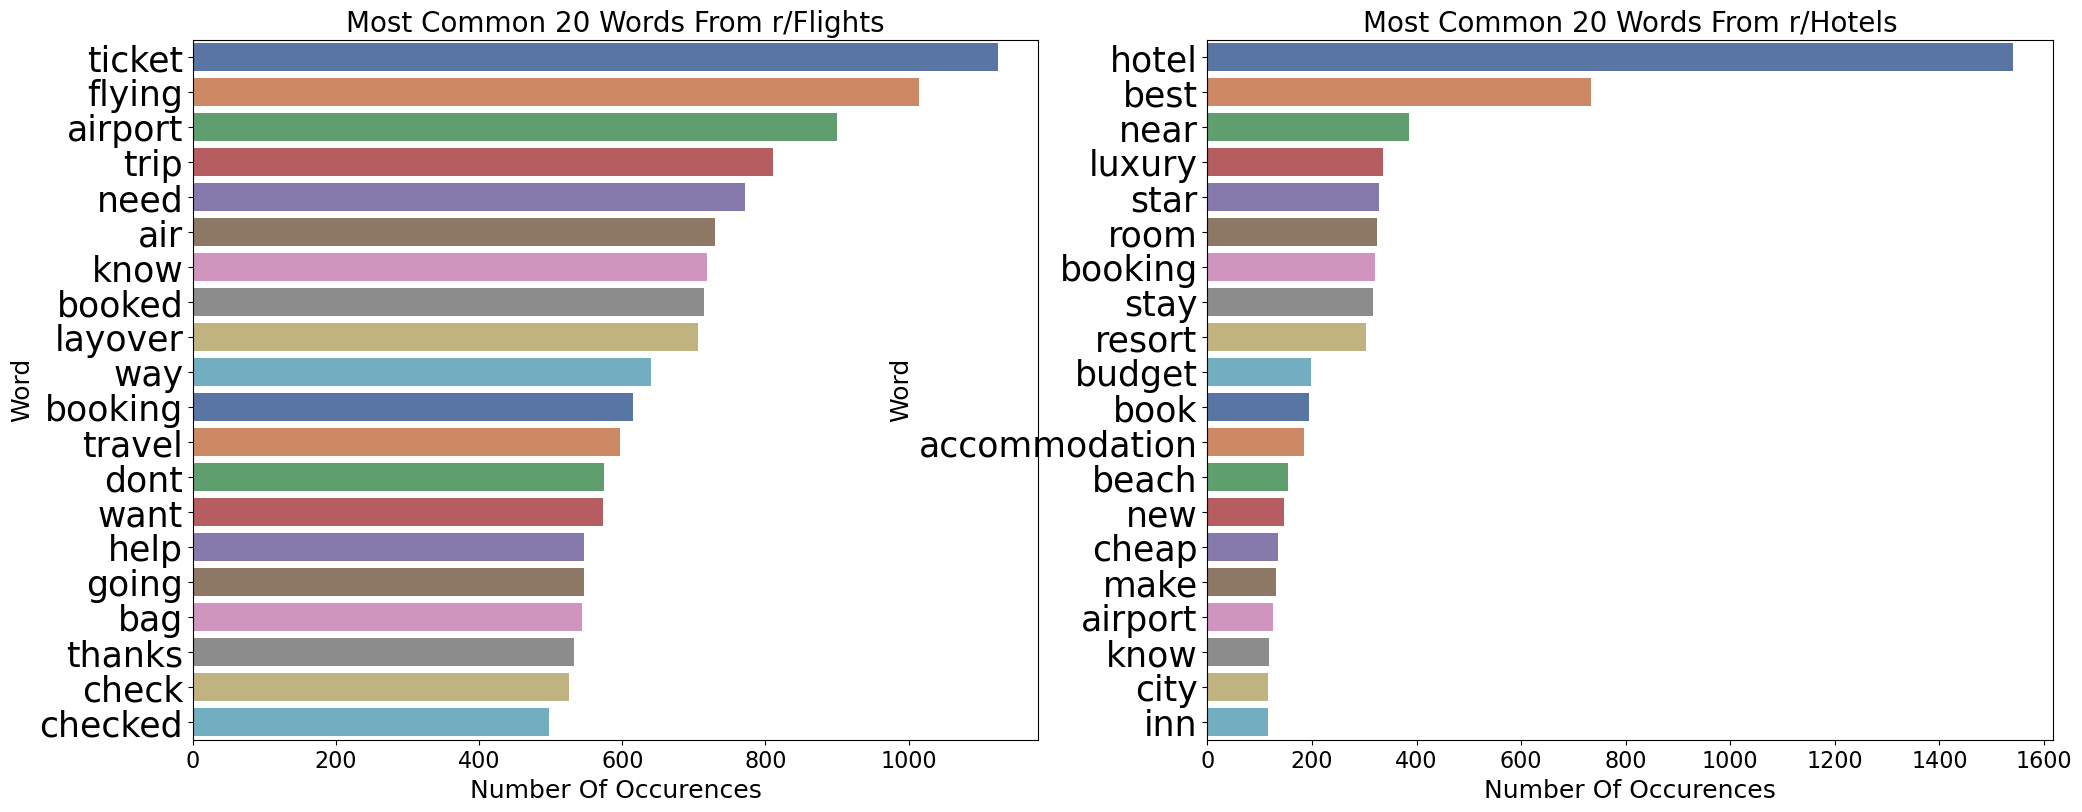

In [31]:
# Saving the vectorized dfs to a new dataframe

flights_vectorized     = pd.DataFrame(vec_flights.toarray(), 
                                      columns = cvec_flights.get_feature_names())
hotels_vectorized = pd.DataFrame(vec_hotels.toarray(), 
                                      columns = cvec_hotels.get_feature_names())

# Getting the 20 most frequent words from each

vectorized_flights     = pd.DataFrame(flights_vectorized.sum().sort_values(ascending = False).head(20))
vectorized_hotels = pd.DataFrame(hotels_vectorized.sum().sort_values(ascending = False).head(20))

# Plotting the most common words

plot_most_frequent_words(dataframes = [vectorized_flights, 
                                       vectorized_hotels],
                         titles     = ["r/Flights", 
                                       "r/Hotels"])



We can see that there are a lot of words that occur in both subreddits. We decided that we should create a list of customized stop words. Furthermore, we noticed that we must lemmatize or stem the text columns because of there are multiple forms of words in the most frequent words such as 'fly' & 'flying' or 'ticket' and 'tickets'. the straight words words like flights hotels we plance to remove as well



## Tokenize Lemmatize

Tokenization is the process of breaking a sequence of text into smaller units called tokens. In natural language processing, tokens are usually words or subwords that are used to represent the text data.

Lemmatizing is the process of reducing a word to its base or root form, which is called the lemma. In linguistics, a lemma is the canonical form of a word, which represents its core meaning. For example, the lemma of the word "running" is "run", and the lemma of the word "better" is "good".

In [32]:
# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text

lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

# Setting up the lemmatizer

lemmatized_posts = []

def lemma(df):
    for post in df["text"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))
    return lemmatized_posts
    


In [33]:
lemmatized_posts = []
lemma(df_flights)

# Appending the lemmatized posts to the dataframe

df_flights["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe

df_flights = df_flights.drop('text', axis=1)
df_flights.head()

,subreddit,lemmatized_text
0,Flights,9AUD Flight To date I international 889AUD 245...
1,Flights,engineer design reverse engineer personal item...
2,Flights,TAP AIR FLIGHT SONG
3,Flights,would awful rule regarding Porter credit Conte...
4,Flights,Air Verification


In [34]:
lemmatized_posts = []
lemma(df_hotels)

# Appending the lemmatized posts to the dataframe

df_hotels["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe


df_hotels = df_hotels.drop('text', axis=1)
df_hotels.head()

,subreddit,lemmatized_text
0,hotels,Double booking egregious cancellation policy H...
1,hotels,Hotel Hello All I currently assistant manager ...
2,hotels,Parking pas
3,hotels,A Journey Through The Hotel Culinary Wonderland
4,hotels,Chime Card Las


In [35]:
df_hotels['lemmatized_text'] = df_hotels['lemmatized_text'].str.lower().str.split()  

In [36]:
df_flights['lemmatized_text'] = df_flights['lemmatized_text'].str.lower().str.split()  

In [39]:
punc_search(df_hotels, 'lemmatized_text', pat_list)

\d special character is present in 0.0 entries
- special character is present in 0.0 entries
\+ special character is present in 0.0 entries
: special character is present in 0.0 entries
! special character is present in 0.0 entries
\? special character is present in 0.0 entries
\. special character is present in 0.0 entries
\n special character is present in 0.0 entries


In [40]:
punc_search(df_flights, 'lemmatized_text', pat_list)

\d special character is present in 0.0 entries
- special character is present in 0.0 entries
\+ special character is present in 0.0 entries
: special character is present in 0.0 entries
! special character is present in 0.0 entries
\? special character is present in 0.0 entries
\. special character is present in 0.0 entries
\n special character is present in 0.0 entries


In [41]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4610 entries, 0 to 4766
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        4610 non-null   object
 1   lemmatized_text  4610 non-null   object
dtypes: object(2)
memory usage: 108.0+ KB


In [42]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4878 entries, 0 to 4932
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        4878 non-null   object
 1   lemmatized_text  4878 non-null   object
dtypes: object(2)
memory usage: 114.3+ KB


#### both dataframe has similar number of count so they are quite balance

In [43]:
# Using pandas.concat() to concat two DataFrames
data = [df_hotels, df_flights]
df = pd.concat(data)
print(df)

     subreddit                                    lemmatized_text
0       hotels  [double, booking, egregious, cancellation, pol...
1       hotels  [hotel, hello, all, i, currently, assistant, m...
2       hotels                                     [parking, pas]
3       hotels  [a, journey, through, the, hotel, culinary, wo...
4       hotels                                 [chime, card, las]
...        ...                                                ...
4927   Flights  [are, always, high, around, 4th, think, go, lo...
4928   Flights  [do, need, id, travel, domestically, i, booked...
4930   Flights  [help, hi, found, looking, help, trip, i, take...
4931   Flights                      [is, bait, switch, southwest]
4932   Flights  [flying, transferring, nervous, hey, my, frien...

[9488 rows x 2 columns]


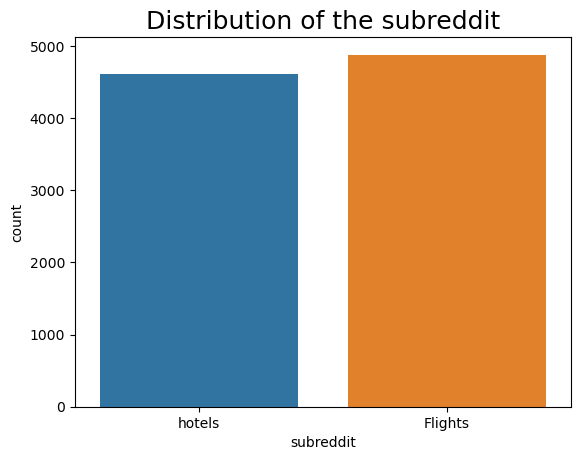

In [44]:

sns.countplot(x=df["subreddit"])
plt.title("Distribution of the subreddit", fontsize = 18); #title


In [45]:
#save a copy of the df
df = df.to_csv('../data/df.csv', index = False)

In [46]:
#Read in the data
df = pd.read_csv('../data/df.csv')
#Check to see if it worked
df.head()

,subreddit,lemmatized_text
0,hotels,"['double', 'booking', 'egregious', 'cancellati..."
1,hotels,"['hotel', 'hello', 'all', 'i', 'currently', 'a..."
2,hotels,"['parking', 'pas']"
3,hotels,"['a', 'journey', 'through', 'the', 'hotel', 'c..."
4,hotels,"['chime', 'card', 'las']"


In [51]:
texts = df['lemmatized_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['subreddit'].values #target

print (X.shape)
print(y.shape)

(9488, 23067)
(9488,)


In [52]:
X

<9488x23067 sparse matrix of type '<class 'numpy.float64'>'
	with 202525 stored elements in Compressed Sparse Row format>

In [53]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'LogisticRegression': LogisticRegression(random_state=42),
              'Multinomial Naive Bayes': MultinomialNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

## Train-test split

In [54]:
#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3,  # 70% train 30% test
                                                    shuffle = True, # shuffles data prior to splitting
                                                    stratify = y, # distribution of classes across train and test
                                                    random_state = 3)# ensures same split each time to allow repeatability

In [167]:
X_train

<6697x35554 sparse matrix of type '<class 'numpy.float64'>'
	with 316268 stored elements in Compressed Sparse Row format>

In [55]:
#Function to get the scores for each model in a df
def model_score_df(df):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(df).reset_index

<bound method DataFrame.reset_index of                 model_name accuracy_score precision_score recall_score  \
2       LogisticRegression       0.929048        0.928932     0.929191   
3  Multinomial Naive Bayes       0.917106        0.921325     0.915758   
0            Random Forest       0.900948        0.900827     0.901068   
1           Decsision Tree        0.88725        0.887405     0.887688   
4       K Nearest Neighbor       0.544784        0.630084     0.555597   

   f1_score  
2  0.929016  
3  0.916657  
0  0.900903  
1  0.887239  
4  0.475151  >

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


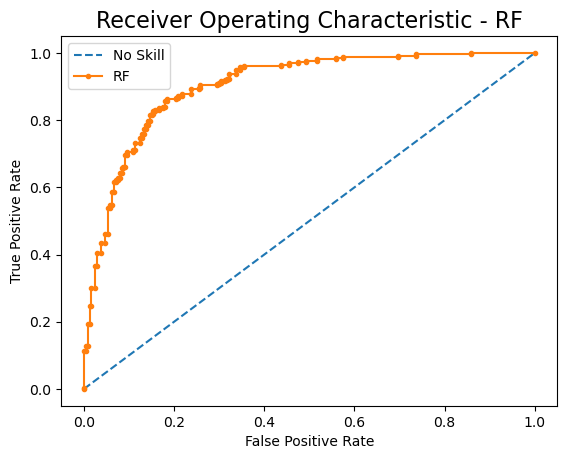

In [57]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RF')
# axis labels
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Conclusions/recommendations



Through the model evalutation, we can see that Logistic Regression is the best score and it seems to be quite high in precision at around 92%. All other models are achieving around the same results indicting its not over train with the train data. Only K Nearest Neighbour perform poorly compared to the others. 

Generally the marketing team can use the 20 words shared to find on the words to use for the SEO strategy as it seems that the logistic regression model had performed well. 

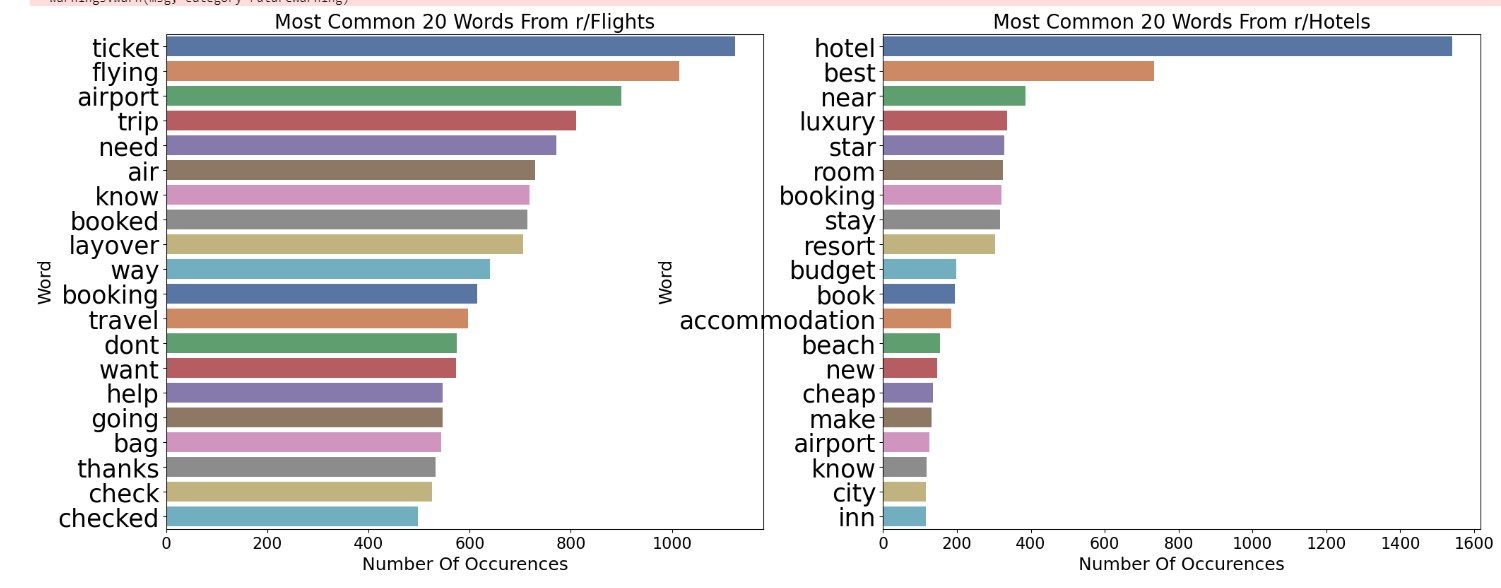

In [70]:
Image(filename='../images/common20words.jpg')